# Wikification

This notebook cointains the code for the neural network which I had to implement as part of my project during the _Honours Programme_ at Sapienza. This task belongs to the category of _Named-entity recognition_ (NER) and the model aims to, given a sentence in natural language (written in english) as input, to recognize parts of the text into Wikipedia entities.

The whole dataset was retrieved from public [XML dumps](https://dumps.wikimedia.org/enwiki/) and then turned into useful information using a small script called __Wikifier__ which simply parses these files and extracts lines of text as well as wikilinks. The final dataset is stored as a collection of 8 files located in the directory __input_data/__. I had to split the dataset into smaller files because I was always running into memory errors but also because it provides modularity (basically you can choose the part of the dataset to use for the training).

The model was trained on a Tesla P100-PCIE-16GB x1 and was able to achieve approximately 91% of accuracy running for 15 epochs.

## Imports

In [2]:
from argparse import Namespace
from collections import Counter
from tqdm import trange
from glob import glob
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from functools import partial
from IPython.core.display import display, HTML
from contextlib import contextmanager,redirect_stderr
from statistics import mean
import json, os, re, string, bz2, nltk, torch, wikipedia, sys, requests, random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.ticker as mtick

nltk.download('punkt')

# Comment lines below if not executing from Google Colab
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Data Vectorization classes

###Dataset

In [0]:
class WikiDataset(Dataset):

    test_slice = 0.10
    val_slice = 0.20
    inner_sep = '_'
    outer_sep = '|'
    link_cutoff = 50

    def __init__(self, dataset):
        
        self._dataset = dataset
        self.train_ds = self._dataset['train']
        self.val_ds = self._dataset['val']
        self.test_ds = self._dataset['test']
        self._lookup_dict = {'train': self.train_ds, 'val': self.val_ds, 'test': self.test_ds}
        self.set_split('train')

    def train_size(self):
        return len(self.train_ds['source_sentences'])

    def val_size(self):
        return len(self.val_ds['source_sentences'])

    def test_size(self):
        return len(self.test_ds['source_sentences'])

    @classmethod
    def is_a_link(cls, word):
        return len(word) >= 2 and word[0] == cls.outer_sep and word[-1] == cls.outer_sep

    @classmethod
    def pre_process(cls, text, strip_punctuation):
        #punctuation = "{[]()},.;:!?~^'\""
        
        source_sentences = [[token.lower() for token in nltk.word_tokenize(source_sentence)] for source_sentence in text.readlines()]
        valid_links = Counter(token.split(cls.outer_sep)[-2] for source_sentence in source_sentences for token in source_sentence if cls.is_a_link(token))
        valid_links = set(link for link,frequence in Counter(valid_links).items() if frequence >= cls.link_cutoff)
        sentences = []
        labels = []

        for source_sentence in source_sentences:
            sentence = []
            label = []
            has_valid_links = False
            for token in source_sentence:
                if cls.is_a_link(token):
                    _split = list(filter(None, token.split(cls.outer_sep)))
                    if len(_split) == 2:
                        text, link = _split
                        if link in valid_links:
                            link = link.replace("_", " ")
                            has_valid_links = True
                        else:
                            link = None
                        sub_links = filter(None, text.split(cls.inner_sep))
                        for sub_link in sub_links:
                            label.append(link)
                            sentence.append(sub_link)
                    else:
                        token = token.replace(cls.outer_sep, ' ').replace(cls.inner_sep, ' ')
                        label.append(None)
                        sentence.append(token)
                else:
                    label.append(None)
                    sentence.append(token)
            if has_valid_links:
                labels.append(label)
                sentences.append(sentence)
        return sentences, labels

    @classmethod
    def read_dataset(cls, ds_path, strip_punctuation):
        text = bz2.open(ds_path, mode='rt', encoding='utf-8')
        sentences, labels = cls.pre_process(text, strip_punctuation)
        train_size = int(len(sentences) * (1 - cls.test_slice - cls.val_slice))
        test_size = int(len(sentences) * cls.test_slice)
        return {
            'train': {'source_sentences': sentences[:train_size], 'target_labels' : labels[:train_size]},
            'test': {'source_sentences': sentences[train_size:train_size+test_size], 'target_labels' : labels[train_size:train_size+test_size]},
            'val': {'source_sentences' : sentences[train_size+test_size:], 'target_labels' : labels[train_size+test_size:]}
        }
    
    @classmethod
    def load_from_files(cls, ds_dir, max_files=-1, file_ext="bz2", strip_punctuation=False):
        ds_dir = ds_dir + "/" if not ds_dir.endswith("/") else ds_dir
        dumps = sorted(glob(ds_dir + "*." + file_ext))
        max_files = len(dumps) if max_files <= -1 else max_files
        ds = {
            'train': {'source_sentences': [], 'target_labels' : []},
            'test': {'source_sentences': [], 'target_labels' : []},
            'val': {'source_sentences': [], 'target_labels' : []}
        }
        for i in trange(min(max(1, max_files), len(dumps)), leave=True, desc="Loading wikidumps"):
            path = dumps[i]
            dump = cls.read_dataset(path, strip_punctuation)
            for split in ds.keys():
                ds[split]['source_sentences'] += dump[split]['source_sentences']
                ds[split]['target_labels'] += dump[split]['target_labels']
        return cls(ds)
        

    def reduce(self, dev):
        train_mean = sum([len(x) for x in self.train_ds['source_sentences']]) / self.train_size()
        val_mean = sum([len(x) for x in self.val_ds['source_sentences']]) / self.val_size()
        test_mean = sum([len(x) for x in self.test_ds['source_sentences']]) / self.test_size()

        self.train_ds['source_sentences'] = [x for x in self.train_ds['source_sentences'] if len(x) <= train_mean*dev]
        self.train_ds['target_labels'] = [y for y in self.train_ds['target_labels'] if len(y) <= train_mean*dev]

        self.val_ds['source_sentences'] = [x for x in self.val_ds['source_sentences'] if len(x) <= val_mean*dev]
        self.val_ds['target_labels'] = [y for y in self.val_ds['target_labels'] if len(y) <= val_mean*dev]

        self.test_ds['source_sentences'] = [x for x in self.test_ds['source_sentences'] if len(x) <= test_mean*dev]
        self.test_ds['target_labels'] = [y for y in self.test_ds['target_labels'] if len(y) <= test_mean*dev]

    def encode_from(self, vocabulary):

        for i, sentence in enumerate(self.train_ds['source_sentences']):
            for j, token in enumerate(sentence):
                self.train_ds['source_sentences'][i][j] = vocabulary.lookup_word(token)

        for i, sentence in enumerate(self.val_ds['source_sentences']):
            for j, token in enumerate(sentence):
                self.val_ds['source_sentences'][i][j] = vocabulary.lookup_word(token)

        for i, sentence in enumerate(self.test_ds['source_sentences']):
            for j, token in enumerate(sentence):
                self.test_ds['source_sentences'][i][j] = vocabulary.lookup_word(token)

        for i, sentence in enumerate(self.train_ds['target_labels']):
            for j, token in enumerate(sentence):
                self.train_ds['target_labels'][i][j] = vocabulary.lookup_link(token)

        for i, sentence in enumerate(self.val_ds['target_labels']):
            for j, token in enumerate(sentence):
                self.val_ds['target_labels'][i][j] = vocabulary.lookup_link(token)

        for i, sentence in enumerate(self.test_ds['target_labels']):
            for j, token in enumerate(sentence):
                self.test_ds['target_labels'][i][j] = vocabulary.lookup_link(token)


    def set_split(self, split="train"):
        """ Selects the splits in the dataset, from 'train', 'val' or 'test' """
        self._target_split = split
        self._target_ds = self._lookup_dict[split]

    def __len__(self):
        return len(self._target_ds['source_sentences'])

    def __getitem__(self, index):
        sentence = self._target_ds['source_sentences'][index]
        links = self._target_ds['target_labels'][index]
        return {'x_source': sentence, 'y_target': links, 'x_source_length' : len(sentence)}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset"""
        return len(self) // batch_size

###Vocabulary

In [0]:
class Vocabulary(object):

    _padding_token = '<PAD>'
    _unknown_token = '<UNK>'
    
    def __init__(self, word_to_index, link_to_index):
        self._word_to_index = word_to_index
        self._link_to_index = link_to_index
        self._index_to_word = {i:w for i,w in enumerate(word_to_index)}
        self._index_to_link = {i:l for i,l in enumerate(link_to_index)}

    def source_size(self):
        return len(self._word_to_index)

    def target_size(self):
        return len(self._link_to_index)
    
    def lookup_word(self, word):
        return self._word_to_index.get(word, 1)

    def lookup_link(self, link):
        return self._link_to_index[link]

    def lookup_word_index(self, index):
        return self._index_to_word.get(index, self._unknown_token)

    def lookup_link_index(self, index):
        return self._index_to_link[index]

    @classmethod
    def of(cls, ds):
        source_vocab = dict()
        target_vocab = dict()
        source_vocab = {cls._padding_token : 0, cls._unknown_token : 1}
        target_vocab = {None : 0}

        # Add words to the Vocabulary from the training set only
        for source_sequence in ds.train_ds['source_sentences']:
            for token in source_sequence:
                if token not in source_vocab:
                    source_vocab[token] = len(source_vocab)

        # Add links to the Vocabulary from train, validation and test set. In fact, 
        # this should not influence predictionsbut provides reliability to the model.
        for target_sequence in ds.train_ds['target_labels']:
            for token in target_sequence:
                if token not in target_vocab:
                    target_vocab[token] = len(target_vocab)

        for target_sequence in ds.val_ds['target_labels']:
            for token in target_sequence:
                if token not in target_vocab:
                    target_vocab[token] = len(target_vocab)

        for target_sequence in ds.test_ds['target_labels']:
            for token in target_sequence:
                if token not in target_vocab:
                    target_vocab[token] = len(target_vocab)

        return cls(source_vocab, target_vocab)

##The Model

In [0]:
class BiLSTM(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, target_size, batch_size, num_layers=1, num_directions=2, padding_idx=0, device='cpu'):
        super(BiLSTM, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.target_size = target_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.num_directions = num_directions
        self.device = device

        self.word_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * num_directions, self.target_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(self.num_layers * self.num_directions, self.batch_size, self.hidden_dim).to(self.device), \
        torch.randn(self.num_layers * self.num_directions, self.batch_size, self.hidden_dim).to(self.device))
    
    def forward(self, sequences, lengths):
        # Reset LSTM hidden state, otherwise the LSTM will treat a new batch as a continuation of a sequence
        self.hidden = self.init_hidden()

        # Dim transformation: (batch_size, seq_size, 1) -> (batch_size, seq_size, embedding_dim)
        embeds = self.word_embedding(sequences)
        embeds = torch.nn.utils.rnn.pack_padded_sequence(embeds, lengths, batch_first=True)

        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        # Please note that output_lengths are the original 'lengths'
        lstm_out, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        batch_size, seq_size, feat_size = lstm_out.shape

        # Dim transformation: (batch_size, seq_size, hidden_size * directions) -> (batch_size * seq_size, hidden_size * directions)
        lstm_out = lstm_out.contiguous().view(batch_size * seq_size, feat_size)

        # Current shape: (batch_size * seq_size, target_size)
        link_outputs = self.fc(lstm_out)
        return link_outputs

##Training Routine

###Helper functions

In [0]:
def _vectorize(indices, padding_index, vector_length):
    vector = np.zeros(vector_length, dtype=np.int)
    vector[:len(indices)] = indices
    vector[len(indices):] = padding_index
    return vector.tolist()

def vectorize(input_sequence, padding_index=0, vector_length=-1):
    if vector_length < 0:
        vector_length = input_sequence['x_source_length']

    source_sequence = _vectorize(input_sequence['x_source'], padding_index, vector_length)
    target_sequence = _vectorize(input_sequence['y_target'], padding_index, vector_length)

    return {'x_source' : source_sequence, 'y_target' : target_sequence, 'x_source_length' : input_sequence['x_source_length']}

def collate_fn(batch, device='cpu'):
    batch.sort(key=lambda sample: sample['x_source_length'], reverse=True)
    local_max_length = batch[0]['x_source_length']
    batch = [vectorize(sequence, vector_length=local_max_length) for sequence in batch]
    output_batch = {'x_source' : [], 'y_target' : [], 'x_source_length' : []}
    for sample in batch:
        output_batch['x_source'].append(sample['x_source'])
        output_batch['y_target'].append(sample['y_target'])
        output_batch['x_source_length'].append(sample['x_source_length'])
    return {'x_source' : torch.LongTensor(output_batch['x_source']).to(device), 'y_target' : torch.LongTensor(output_batch['y_target']).to(device), 'x_source_length' : torch.LongTensor(output_batch['x_source_length']).to(device)}

def compute_accuracy(y_hat, y, mask_index=0):
    y_hat = torch.argmax(y_hat, dim=1)
    y = y.view(-1)
    correct_indices = torch.eq(y_hat, y).float()
    valid_indices = torch.ne(y, mask_index).float()
    n_correct = (correct_indices * valid_indices).sum().item()
    n_valid = max(1, valid_indices.sum().item())
    return n_correct / n_valid * 100

def annotate(input, stopwords, args):
    ''' Use input sentences as the input of our model '''

    # Vectorize input
    sentences = [nltk.word_tokenize(sentence) for sentence in nltk.sent_tokenize(input)]
    lengths = torch.LongTensor([[len(sentence)] for sentence in sentences])
    input_vectors = [torch.LongTensor([[vocabulary.lookup_word(word.lower()) for word in sentence]]).to(args.device) for sentence in sentences]

    # Consider the output of the Net as a distribution of probability and take the links with the highest scores
    softmax = nn.Softmax(dim=1)
    predictions = [softmax(model(sentence, length)) for i, (sentence, length) in enumerate(zip(input_vectors, lengths))]
    predictions = [[tensor.tolist() for tensor in torch.topk(predictions[i], args.top_k, dim=1)] for i in range(len(predictions))]
    scores, predictions = list(zip(*predictions))
    predictions = [[[vocabulary.lookup_link_index(token_index) for token_index in token_indices] for token_indices in sequence_indices] for sequence_indices in predictions]

    # Pick up links and form output sentences which contains hyperlinks
    output_sentences = []
    for sentence_predictions, sentence_scores, sentence in zip(predictions, scores, sentences):
        output_sentence = []
        for i, (top_predictions, top_scores) in enumerate(zip(sentence_predictions, sentence_scores)):
            #print(sentence[i] +": ",list(zip(top_predictions, top_scores)))    # debug
            word = sentence[i]
            output_sentence.append(annotate_word(word, top_predictions, top_scores, args, stopwords))
        output_sentence = unify_links(output_sentence, sentence)
        output_sentences.append(" ".join(output_sentence))
    return """<h4>""" + " ".join(output_sentences) + """</h4>"""

@contextmanager
def suppress_stderr():
    """A context manager that redirects stdout and stderr to devnull"""
    with open(os.devnull, 'w') as fnull:
        with redirect_stderr(fnull) as err:
            yield (err)

def annotate_word(word, top_predictions, top_scores, args, stopwords):
    ''' Choose a link from model's predictions according to the scores they achieved for that particular word. '''
    if word in stopwords:
        return (word,False)
    link = None
    for i in range(args.top_k):
        if link is not None:
            return (link,True)
        if top_predictions[i] not in stopwords and top_scores[i] > args.perplexity:
            link = get_wikilink(word, top_predictions[i])

    # Below here we try to enhance model predictions by gathering information from all of the top_links
    if top_scores[0] <= args.perplexity or top_predictions[0] in stopwords:
        return (link,True) if link is not None else (word,False)

    for i in range(1, args.top_k):
        if link is not None:
            return (link,True)
        if mean([top_scores[0], top_scores[i]]) > args.perplexity:
            # This time try concatenating couples of links which are considered enoguh confident
            link = get_wikilink(word, top_predictions[0] + " " + top_predictions[i])
    return (link,True) if link is not None else (word,False)

###General utilities

In [0]:
def make_state():
    return {'train_loss' : [], 'train_acc' : [], 'val_loss' : [], 'val_acc' : [], 'test_loss' : -1, 'test_acc' : -1}

def plot_results(train_state, save_path=None):
    epochs = len(train_state['train_loss'])
    plt.rcParams["figure.figsize"] = (16,12)
    plt.style.use('fivethirtyeight')
    loss_plot = plt.subplot(211)
    loss_plot.set_xticks(np.arange(0, epochs, 1.0))
    plt.title('model loss', fontsize=14)
    plt.plot(train_state['train_loss'], label='train')
    plt.plot(train_state['val_loss'], label='validation')
    plt.ylabel('loss', fontsize=12)
    plt.xlabel('epoch', fontsize=12)
    plt.legend()
    accuracy_plt = plt.subplot(212)
    accuracy_plt.yaxis.set_major_formatter(mtick.PercentFormatter())
    accuracy_plt.set_xticks(np.arange(0, epochs, 1.0))
    plt.title('model accuracy', fontsize=14)
    plt.plot(train_state['train_acc'], label='train')
    plt.plot(train_state['val_acc'], label='validation')
    plt.ylabel('accuracy', fontsize=12)
    plt.xlabel('epoch', fontsize=12)
    plt.legend()
    plt.subplots_adjust(hspace=0.4)
    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()
    plt.close()

def save_model(model, train_state, vocabulary, args):
    epochs = len(train_state['train_loss'])
    state = {
        'state_dict': model.state_dict(),
        'vocabulary': vocabulary,
    }
    torch.save(state, os.path.join(args.save_dir + args.model_state_file))
    train_state_path = os.path.join(args.save_dir, args.train_state_file)
    plot_results(train_state, save_path=train_state_path+".jpg")
    with open(train_state_path+".json", 'w') as f_out:
        json.dump(train_state, f_out)
    
def format_link(text, link):
    return """<a href="{}" target="_blank">{}</a>""".format(link, text)

def get_wikilink(word, link):
    ''' This function is responsible for converting actual links (keywords) into real wikipedia links. '''
    link = "_".join(link.split())
    response = requests.request(method='HEAD', url="https://en.wikipedia.org/wiki/{}".format(link.capitalize()))
    if response.status_code == requests.codes.ok:
        return response.url
    try:
        # Suppress errors form Wikipedia library as described here: https://github.com/goldsmith/Wikipedia/pull/112
        with suppress_stderr():
            return wikipedia.page(link.title()).url
    except:
        return None

def load_file(path):
    ''' Read a file of data separated by newlines. '''
    with open(path, 'r') as f:
        result_file = f.read().splitlines()
    return result_file

def unify_links(link_sequence, original_sentence):
    ''' This is responsible for merging links which include more words in one sigle link, just to prettify. '''
    output_sentence = []
    link_tokens = []
    for i, (token, is_link) in enumerate(link_sequence):
        if is_link:
            last_link, _ = link_sequence[i-1]
            if len(link_tokens) > 0 and token != last_link:
                # Check if it's another link
                tokens = " ".join(link_tokens)
                link_tokens = []
                output_sentence.append(format_link(tokens, last_link))

            link_tokens.append(original_sentence[i])
        else:
            if len(link_tokens) > 0:
                tokens = " ".join(link_tokens)
                link_tokens = []
                last_link, _ = link_sequence[i-1]
                output_sentence.append(format_link(tokens, last_link))
            output_sentence.append(token)

    if len(link_tokens) > 0:
        tokens = " ".join(link_tokens)
        last_link, _ = link_sequence[-1]
        output_sentence.append(format_link(tokens, last_link))
    return output_sentence

def store_test_sentences(dataset, path):
    output_data = [" ".join(sentence) for sentence in dataset.test_ds['source_sentences']]
    with open(path, 'w') as f_out:
        f_out.write("\n".join(output_data))

###Settings

In [9]:
args = Namespace(
    dataset_path="drive/My Drive/Wikifier/input_data/",
    max_files = -1,
    dev=3,
    save_dir="drive/My Drive/Wikifier/",
    model_state_file="model.pth",
    train_state_file="model_performance",
    stopwords_file="stopwords.txt",
    test_file="sentences.txt",
    save_model=False,
    embedding_dim = 128,
    hidden_dim = 128,
    learning_rate = 0.001,
    weight_decay = 0.0001,
    batch_size = 512,
    perplexity=0.28,
    top_k=3,
    inference_batch_size = 1,
    shuffle = True,
    drop_last = True,
    epochs = 15,
    device="cuda"
)

if not torch.cuda.is_available():
    print("Running model using CPU")
    args.device = 'cpu'
else:
    print("Running model on GPU:", torch.cuda.get_device_name(0), "x" + str(torch.cuda.device_count()))

Running model on GPU: Tesla P100-PCIE-16GB x1


###Initializations

In [0]:
dataset = WikiDataset.load_from_files(args.dataset_path, max_files=args.max_files)
dataset.reduce(dev=args.dev)
store_test_sentences(dataset, path=args.save_dir+args.test_file)
vocabulary = Vocabulary.of(dataset)
dataset.encode_from(vocabulary)


model = BiLSTM(vocab_size=vocabulary.source_size(), embedding_dim=args.embedding_dim, hidden_dim=args.hidden_dim, \
               target_size=vocabulary.target_size(), batch_size=args.batch_size, device=args.device).to(args.device)
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
criterion = nn.CrossEntropyLoss(ignore_index=0)
train_state = make_state()

###Training loop

In [0]:
for epoch in range(args.epochs): 

    # Training

    dataset.set_split('train')
    dataloader = DataLoader(dataset=dataset, batch_size=args.batch_size, shuffle=args.shuffle, drop_last=args.drop_last, collate_fn=partial(collate_fn, device=args.device))
    batch_generator = iter(dataloader)

    running_loss = 0.0
    running_acc = 0.0
    model.train()

    for batch_index in trange(len(batch_generator), leave=True, desc="Train progress"):
        batch = batch_generator.next()

        optimizer.zero_grad()

        x, y, x_len = batch.values()
        y_hat = model(x, x_len)

        loss = criterion(y_hat, y.view(-1))
        loss.backward()

        optimizer.step()

        running_loss += (loss.item() - running_loss) / (batch_index + 1)
        acc_t = compute_accuracy(y_hat, y)
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)

    # Validation

    dataset.set_split('val')
    dataloader = DataLoader(dataset=dataset, batch_size=args.batch_size, shuffle=args.shuffle, drop_last=args.drop_last, collate_fn=partial(collate_fn, device=args.device))
    batch_generator = iter(dataloader)

    running_loss = 0.0
    running_acc = 0.0
    model.eval()

    for batch_index in trange(len(batch_generator), leave=True, desc="Validation progress"):
        batch = batch_generator.next()

        x, y, x_len = batch.values()
        y_hat = model(x, x_len)

        loss = criterion(y_hat, y.view(-1))

        running_loss += (loss.item() - running_loss) / (batch_index + 1)
        acc_t = compute_accuracy(y_hat, y)
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)

# Test

dataset.set_split('test')
dataloader = DataLoader(dataset=dataset, batch_size=args.batch_size, shuffle=args.shuffle, drop_last=args.drop_last, collate_fn=partial(collate_fn, device=args.device))
batch_generator = iter(dataloader)

running_loss = 0.0
running_acc = 0.0
model.eval()

for batch_index in trange(len(batch_generator), leave=True, desc="Test"):
    batch = batch_generator.next()

    x, y, x_len = batch.values()
    y_hat = model(x, x_len)

    loss = criterion(y_hat, y.view(-1))

    running_loss += (loss.item() - running_loss) / (batch_index + 1)
    acc_t = compute_accuracy(y_hat, y)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

###Visualize the output

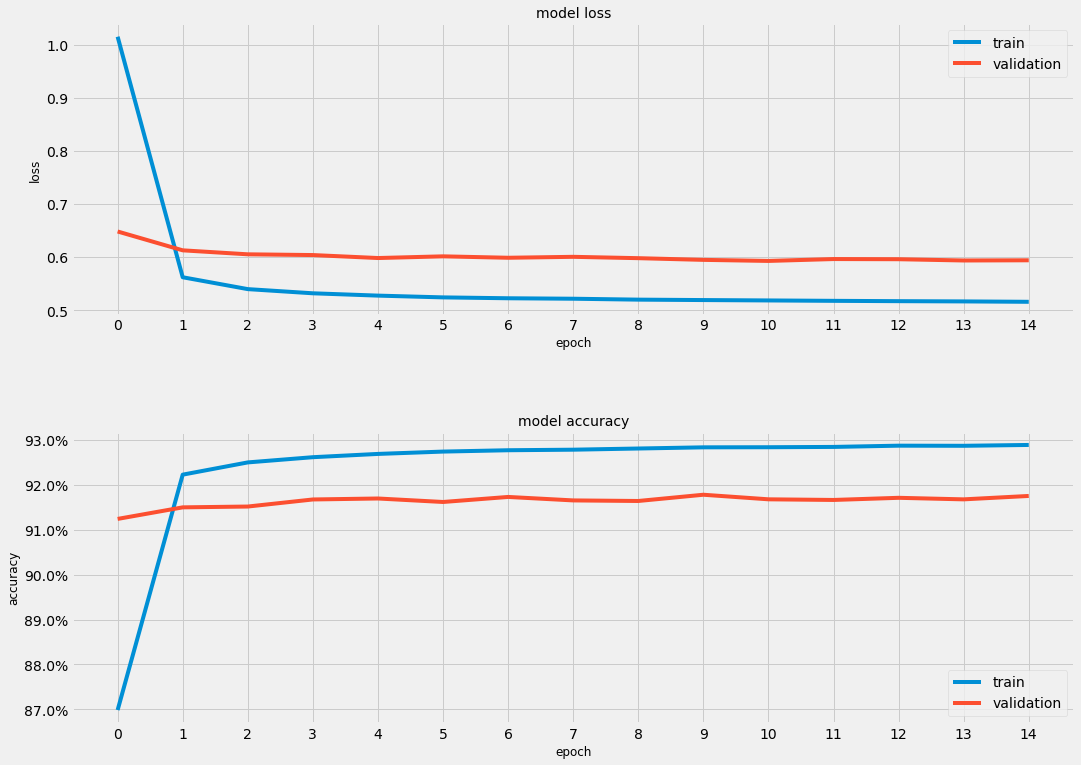

In [12]:
plot_results(train_state)
if args.save_model:
    save_model(model, train_state, vocabulary, args)

##Inference

###Initializations

In [0]:
# Load the model which was previously trained
state = torch.load(args.save_dir + args.model_state_file)
vocabulary = state['vocabulary']
model = BiLSTM(vocab_size=vocabulary.source_size(), embedding_dim=args.embedding_dim, hidden_dim=args.hidden_dim, target_size=vocabulary.target_size(), batch_size=args.inference_batch_size, device=args.device).to(args.device)
model.load_state_dict(state['state_dict'])
with open(args.save_dir + args.train_state_file + ".json") as json_data:
    train_state = json.load(json_data)

# Put the model in evaluation mode since it used for inference
model.eval()

# Set the API to retrieve results in English, load the list of stopwords that should not be annotated and random sentences for testing the model
wikipedia.set_lang("en")
stopwords = load_file(os.path.join(args.save_dir, args.stopwords_file))
test_sentences = load_file(os.path.join(args.save_dir, args.test_file))

###Testing

In [15]:
# Just an example sample sentence randomly picked from the test set
sample_sentence = random.choice(test_sentences).capitalize()

# Your test sentence here
#sample_sentence = "The Councils of Carthage were church synods held during the 3rd, 4th, and 5th centuries in the city of Carthage in Africa."

y = annotate(sample_sentence, stopwords, args)
display(HTML(y))

##Future improvements and considerations

Since the model has been trained until a maximum of 15 epochs so far, it would be worth experiment longer training and maybe introduce early stopping to avoid overfitting on the dataset.

Without doubts, the model would benefit from having real links instead of link keywords because sometimes the model correctly annotates an entity with the right link but then fails when converting the link to a valid URL.

Currently, I don't have the chance to test the model using a larger input size but it would worth trying to incorporate morphological information about words being read when making predictions.